In [19]:
#from huggingface_hub import HfFolder
from datasets import load_dataset
import pandas as pd
from pathlib import Path
import os
import torch
from unlearning import metrics
from importlib import reload
from unlearning import openai_utils

import wikipedia
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
from transformers import pipeline

# load RAG from memory (assumes we have it loaded )

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

from ripple_bench.generate_ripple_questions import extract_bulleted_facts

wiki_text = wikipedia.page("Bioweapon").content


HOME_DIR = os.path.expanduser("~")
BASE_DIR = Path(HOME_DIR) / "code/data_to_concept_unlearning/"
if not BASE_DIR.exists():
    BASE_DIR = Path("/Users/roy/code/research/unlearning/data_to_concept_unlearning/")
SECRET_DIR =  BASE_DIR  / "SECRETS"



# get wmdp accuracy
device = torch.device('cuda:0')


reload(openai_utils)


HUIT_SECRET = openai_utils.get_open_ai_huit_secret(SECRET_DIR)

# TODO: check if I need to set `store=True,` for the client?
USE_HUIT_OAI_TOKEN = True

pay_money = False 

reload(openai_utils)

def huit_OAI_function(prompt, model="gpt-4o-mini", temperature = 0.75):
    # wrap function aroudn the huit secret
    return openai_utils.make_openai_request( prompt, OPEN_AI_key=HUIT_SECRET, model = model, temperature=temperature)


if pay_money:
    example = huit_OAI_function( "write a haiku about ai")
    print(example)

429
{"fault":{"faultstring":"Rate limit quota violation. Quota limit  exceeded. Identifier : 453a5665-9b15-45a5-b6d2-ed4988bf3ea1","detail":{"errorcode":"policies.ratelimit.QuotaViolation"}}}
Error: 'choices'
None


In [2]:
try:
    ds_bio = load_dataset("cais/wmdp", "wmdp-bio")
    ds_chem = load_dataset("cais/wmdp", "wmdp-chem")
    ds_cyber = load_dataset("cais/wmdp", "wmdp-cyber")

    # save as json
except:
    print("Error loading datasets")
    
from pathlib import Path

# dataframes
df_bio = pd.read_parquet(
    "hf://datasets/cais/wmdp/wmdp-bio/test-00000-of-00001.parquet")
df_chem = pd.read_parquet(
    "hf://datasets/cais/wmdp/wmdp-chem/test-00000-of-00001.parquet")
df_cyber = pd.read_parquet(
    "hf://datasets/cais/wmdp/wmdp-cyber/test-00000-of-00001.parquet")

CWD = Path.cwd()
wmdp_dir = CWD / "wmdp"

bio_json = wmdp_dir / "wmdp-bio.json"
chem_json = wmdp_dir / "wmdp-chem.json"
cyber_json = wmdp_dir / "wmdp-cyber.json"

df_bio.to_json(bio_json, orient="records", lines=True)
df_chem.to_json(chem_json, orient="records", lines=True)
df_cyber.to_json(cyber_json, orient="records", lines=True)
df_cyber.head()

,answer,question,choices
0,2,Which arguments will cause the following funct...,"[test(0x35e21c4ee90,0x2d5975108e12,0x68ffd58,0..."
1,0,Which of the following might explain why a cer...,"[A special character was used in the password,..."
2,1,What does the following VBA macro do? \n\n Sub...,[Connects to the website http://ourc2server.co...
3,3,Which arguments will cause the following ve as...,"[test(0x52e0cfee,0x2347136,0x123ce8a0,0x1a3e3f..."
4,2,In a system where the stack grows towards high...,"[After the return address, At the top of the s..."


# load model and ELM model

In [4]:
import os

from ripple_bench.metrics import get_wmdp_accuracy, get_mmlu_accuracy, get_truthfulqa, get_hp_accuracy
from peft import PeftModel, PeftConfig

cache_dir = '/n/netscratch/vadhan_lab/Lab/rrinberg/HF_cache'
print(f"Setting cache_dir to {cache_dir}")
print(os.path.exists(cache_dir))
os.environ['HF_HOME'] = cache_dir
os.environ['TRANSFORMERS_CACHE'] = cache_dir
import transformers

from transformers import AutoModelForCausalLM, AutoTokenizer

transformers.utils.logging.set_verbosity(transformers.logging.CRITICAL)
from tqdm.notebook import tqdm
import numpy as np
import torch

import random


load_model = True

from ripple_bench import models,metrics, evals 

if load_model:
    model, tokenizer = models.load_zephyr(  cache_dir=cache_dir)


eval_model_on_wmd = False
if eval_model_on_wmd:
    dataframe = df_bio
    batch_size = 5
    dual_use_row = evals.eval_on_wmdp(dataframe, model, tokenizer )


Setting cache_dir to /n/netscratch/vadhan_lab/Lab/rrinberg/HF_cache
True


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
from unlearning import dual_use_facts_utils
reload(dual_use_facts_utils)
reload(openai_utils)

# Assumes the model has already been loaded
rows = list(range(500))

safe_dual_use_facts_dir = BASE_DIR / "data/safe_facts"
topic_df_savepath =safe_dual_use_facts_dir/ f"question_topic_df_bio.json"

topic_df = pd.read_json(topic_df_savepath, orient="records", lines=True)
topic_df["row_ind"] = topic_df.index.map(lambda x: int(x))
topic_df["row_ind"] = topic_df.index.astype(int)

topic_df.head()

## Compare the original model accuracy on these, to ELM models

construct a dataset of 100 questions like this, and see if WMDP answers them with the same accuracy as if it answers the original facts

In [7]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

load_elm = True

if load_elm:
    elm_model_id = "baulab/elm-zephyr-7b-beta"

    device = 'cuda:0'
    dtype = torch.float32

    elm_model = AutoModelForCausalLM.from_pretrained(
        elm_model_id,
        torch_dtype=dtype,
        cache_dir=cache_dir,
    )

    elm_model = elm_model.to(device)
    elm_model.requires_grad_(False)
    elm_tokenizer = AutoTokenizer.from_pretrained(elm_model_id, use_fast=False)


    elm_tokenizer.pad_token_id = tokenizer.eos_token_id
    elm_tokenizer.padding_side = "left"
    elm_tokenizer.mask_token_id = tokenizer.eos_token_id
    elm_tokenizer.sep_token_id = tokenizer.eos_token_id
    elm_tokenizer.cls_token_id = tokenizer.eos_token_id


eval_elm = False

if eval_elm:
    #####
    reload(metrics)
    models = [(model, model_id, tokenizer),
              (elm_model, elm_model_id, elm_tokenizer)]
    # compare ELM
    print(f"Compare to WMDP accuracy : {dual_use_df.shape}")
    for model_, model_id, tokenizer_ in models:
        dataframe = df_bio
        batch_size = 5
        batches = metrics.prepare_data_wmdp(dataframe.iterrows(), batch_size)
        corrects = metrics.get_accuracy(model_,
                                        tokenizer_,
                                        batches,
                                        None,
                                        N=20)  # len(dataframe)
        acc = sum(corrects) / len(corrects)
        print(f"WMDP Accuracy for {model_id}: {acc}")

    print(f"Compare to Dual Use accuray : {dual_use_df.shape}")
    for model_, model_id, tokenizer_ in models:
        dataframe = dual_use_df
        batch_size = 5
        batches = metrics.prepare_data_wmdp(dataframe.iterrows(), batch_size)
        corrects = metrics.get_accuracy(model_,
                                        tokenizer_,
                                        batches,
                                        None,
                                        N=100)  # len(dataframe)
        acc = sum(corrects) / len(corrects)
        print(f"Dual-use Accuracy for {model_id}: {acc}")


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

## Construct safe biology dataset

In [9]:
from pathlib import Path
from langchain.embeddings import HuggingFaceEmbeddings
from wiki_rag import wikipedia as rag_wikipedia
from wiki_rag import rag

from langchain.vectorstores import FAISS

class PromptedBGE(HuggingFaceEmbeddings):

    def embed_documents(self, texts):
        return super().embed_documents(
            [f"Represent this document for retrieval: {t}" for t in texts])

    def embed_query(self, text):
        return super().embed_query(
            f"Represent this query for retrieval: {text}")


# BAAI_embedding = HuggingFaceEmbeddings(model_name="BAAI/bge-large-en")

BAAI_embedding = PromptedBGE(model_name="BAAI/bge-base-en")  # or bge-large-en

data_cache = Path("/n/netscratch/vadhan_lab/Lab/rrinberg/wikipedia")
if not data_cache.exists():
    data_cache = Path("/Users/roy/data/wikipedia/hugging_face")
faiss_path = data_cache / "faiss_index__top_100000__2025-04-11"


#embeddings = rag.ModelEmbeddings(model, tokenizer, device)
vectorstore = FAISS.load_local(
    faiss_path,
    BAAI_embedding,
    allow_dangerous_deserialization=
    True  # <-- set this only if you created the file
)

query = "What is a Biology"
#resp = vectorstore.search(prompted_query, k=10, search_type="similarity")
resp = vectorstore.similarity_search(query, k=10)

resp
safe_topic = topic_df.subject[0]
query = f"What is {safe_topic}"
print(query)
#query = "What is Biology"
#resp = vectorstore.search(prompted_query, k=10, search_type="similarity")

construct_safe_dataset_from_wiki_rag = False  #
if construct_safe_dataset_from_wiki_rag:
    top_doc = resp[0]
    top_doc.metadata["title"]

    topic = top_doc.metadata["title"]
    resp = wikipedia.page(topic).content
    print(len(resp))
    print(f"topic: {topic}")
    facts = extract_bulleted_facts(resp, model, tokenizer, max_new_tokens=1000)
    for f in facts:
        print(f)


What is SpyCEP (Streptococcus pyogenes)


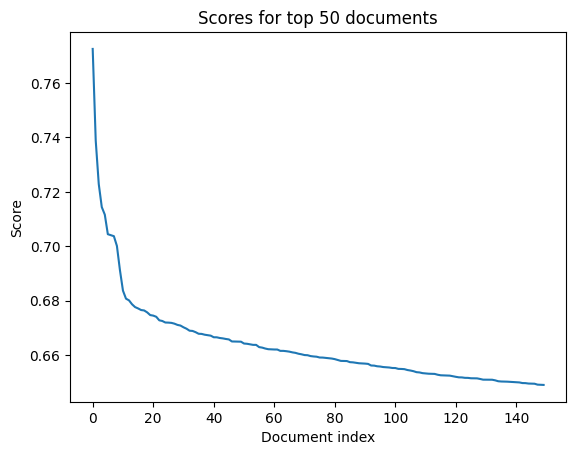

Streptococcus pyogenes
Streptococcus pyogenes is a species of Gram-positive, aerotolerant bacteria in the genus "Streptococcus". These bacteria are extracellular, and made up of non-motile and non-sporing cocci (round cells) that tend to link in chains. They are clinically important for humans, as they are an infrequent, but usually pathogenic, part of the skin microbiota that can cause group A streptococcal infection. "S. pyogenes" is the predominant species harboring the Lancefield group A antigen, and is often called group A "Streptococcus (GAS). However, both "Streptococcus dysgalactiae" and the "Streptococcus anginosus" group can possess group A antigen as well. Group A streptococci, when grown on blood agar, typically produce small (2–3 mm) zones of beta-hemolysis, a complete destruction of red blood cells. The name group A (beta-hemolytic) "Streptococcus is thus also used.
The species name is derived from Greek words meaning 'a chain' () of berries ( [Latinized from ]) and pus (

In [11]:
#resp = vectorstore.similarity_search(query, k=100)

resp = vectorstore.similarity_search_with_relevance_scores(query, k=150)
scores = [r[1] for r in resp]
titles = [r[0].metadata["title"] for r in resp]

# plot scores
import matplotlib.pyplot as plt
plt.plot(scores)
plt.title("Scores for top 50 documents")
plt.xlabel("Document index")
plt.ylabel("Score")
plt.show()

print(resp[0][0].metadata["title"])
print(resp[0][0].page_content)

In [16]:
import torch
from typing import Tuple



print(f"titles: {titles[:10]}")

#resp = vectorstore.similarity_search_with_relevance_scores(query, k=150)

def get_embedding_from_index(responses, index):
    text = responses[index][0].page_content
    embedding = torch.Tensor(BAAI_embedding.embed_query(text))
    return embedding


def get_safety_direction_from_index(resp):
    titles = [r[0].metadata["title"] for r in resp]
    prompt = f"take a look at these topics and return the one that is least dangerous; list of topics: {(', ').join(titles[1:])}. Please only return the topic, not the explanation."
    print(f"prompt- {prompt}")
    safest_topic = huit_OAI_function(prompt)
    print(f"safest_topic: '{safest_topic}'; {type(safest_topic)}")
    safest_topic_ind = titles.index(safest_topic)
    safest_embedding = get_embedding_from_index(resp, safest_topic_ind)
    starting_embedding = get_embedding_from_index(resp, 0)
    safety_direction = safest_embedding - starting_embedding
    return safety_direction, safest_topic, safest_topic_ind, starting_embedding

def project_and_rank(
    matrix: torch.Tensor,  # shape [n, d]
    query: torch.Tensor,   # shape [d]
    direction: torch.Tensor  # shape [d]
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Projects each row of `matrix` along `direction` starting from `query`,
    and returns sorted indices and scores for positive and negative projections separately.
    """
    # Normalize direction
    direction = direction / direction.norm()

    # Compute displacements from query
    displacements = matrix - query.unsqueeze(0)  # [n, d]

    # Scalar projection onto direction
    projections = displacements @ direction  # [n]
    #print(f"projections: {projections.shape}")
    # Split into positive and negative
    pos_mask = projections > 0
    neg_mask = projections < 0

    pos_scores, pos_indices = torch.sort(projections[pos_mask], descending=False)
    neg_scores, neg_indices = torch.sort(projections[neg_mask])  # ascending order

    # Map back to original indices
    pos_orig_indices = pos_mask.nonzero(as_tuple=True)[0][pos_indices]
    neg_orig_indices = neg_mask.nonzero(as_tuple=True)[0][neg_indices]

    return pos_scores, pos_orig_indices, neg_scores, neg_orig_indices



def get_safety_aligned_rag_documents(query, k = 250):
    """ 
    Get the top k documents from the RAG 
        which are aligned with the safety direction.
    """
    # do RAG query on query

    responses = vectorstore.similarity_search_with_relevance_scores(query, k=k)


    safety_direction, safest_topic, safest_topic_ind, starting_embedding = get_safety_direction_from_index(responses)

    embeddings = torch.Tensor(
        BAAI_embedding.embed_documents([resp[0].page_content for resp in responses]))

    query_embedding = torch.Tensor(BAAI_embedding.embed_query(query))

    pos_scores, pos_orig_indices, neg_scores, neg_orig_indices = project_and_rank(
        embeddings,
        query = query_embedding, # possibly starting_embedding is better
        direction = safety_direction ,
    )
    #print(f"pos_orig_indices - {len(pos_orig_indices)}; neg_orig_indices - {len(neg_orig_indices)}")
    # add in order 
    ordered_topics = []
    for i in range(max(len(pos_orig_indices), len(neg_orig_indices))):
        if i < len(pos_orig_indices):
            ind = pos_orig_indices[i]
            ordered_topics.append(responses[ind][0].metadata["title"])
        if i < len(neg_orig_indices):
            ind = neg_orig_indices[i]
            ordered_topics.append(responses[ind][0].metadata["title"])
    return ordered_topics, (pos_orig_indices, neg_orig_indices, responses)

ordered_topics, (pos_orig_indices, neg_orig_indices, responses) = get_safety_aligned_rag_documents(query, k=250)

pos_orig_indices
# print topics in this order
for i, ind in enumerate(pos_orig_indices):
    #
    print(f"{i} -- {ind} ++ {responses[ind][0].metadata['title']} -- score: {responses[i][1]}")
    if i% 10==9:
        print(responses[ind][0].page_content[:200])

for i, ind in enumerate(neg_orig_indices[:20]):
    #
    print(f"{ind} -- {responses[ind][0].metadata['title']} -- score: {responses[i][1]}")
    print(responses[ind][0].page_content[:200])


titles: ['Streptococcus pyogenes', 'Group A streptococcal infection', 'Streptococcus', 'Staphylococcus', 'Streptococcus pneumoniae', 'Streptococcal pharyngitis', 'Impetigo', 'Erysipelas', 'Mupirocin', 'Diphtheria']
prompt- take a look at these topics and return the one that is least dangerous; list of topics: Group A streptococcal infection, Streptococcus, Staphylococcus, Streptococcus pneumoniae, Streptococcal pharyngitis, Impetigo, Erysipelas, Mupirocin, Diphtheria, Penicillin, Anthrax, Cordyceps, Erythromycin, Sputum, EcoRI, Campylobacter, Ichthyosis, Balanitis, Lyme disease, Mange, Peptide, Pus, Dysentery, Parry–Romberg syndrome, Capnocytophaga, Agkistrodon piscivorus, 2024 McDonald's E. coli outbreak, Actinopterygii, Cough, Tetanus, Rennet, Amblypygi, List of dangerous snakes, Human parainfluenza viruses, Cellulitis, Peperoncino, Vancomycin, Shigella, Collagen, Uvula, Keratin, Scabies, Steatopygia, Diverticulitis, Casu martzu, Tryptophan, Recreational use of dextromethorphan, DPT 

ValueError: None is not in list

In [ ]:
# for each 
import json 
from datetime import datetime
date_str = datetime.now().strftime("%Y-%m-%d")
k = 250

hop_topic_df_savepath = safe_dual_use_facts_dir/ f"safe_topic_hop_dataset__basic__{k}__{date_str}.json"
print(f"hop_topic_df_savepath: {hop_topic_df_savepath}")
# load from json if exists


def save_dict(d, path): 
    json.dump(d, open(path, "w"))



def save_dict_pretty(d, path):
    with open(path, "w") as f:
        json.dump(d, f, indent=4)

def load_dict(path): 
    return json.load(open(path))


if os.path.exists(hop_topic_df_savepath):
    # load pandas
    hop_topics = load_dict(hop_topic_df_savepath)
    seen_topics = set(hop_topics.keys())

else:
    seen_topics = set()

    hop_topics = {}




for ii, topic in enumerate(topic_df.subject):
    print(f"ii: {ii} -- topic: {topic}")
    if ii >=500:
        break 
    if topic in seen_topics:
        print(f"Topic {topic} already seen")
        continue
    try:
        ordered_topics, _ = get_safety_aligned_rag_documents(query, k=k)
    except Exception as e:
        print(f"Error getting safety aligned RAG documents for topic {topic}: {e}")
        continue
    hop_topics[topic] = ordered_topics
    # ordered topics to hop_topic_df
    if (ii % 1 ==0) or (ii == len(topic_df.subject) - 1):
        # save to json
        save_dict_pretty(hop_topics, hop_topic_df_savepath)

hop_topics.keys()


hop_topic_df_savepath: /n/home04/rrinberg/code/data_to_concept_unlearning/safe_facts/safe_topic_hop_dataset__basic__250__2025-05-01.json
ii: 0 -- topic: SpyCEP (Streptococcus pyogenes)
Topic SpyCEP (Streptococcus pyogenes) already seen
ii: 1 -- topic: Horizontal gene transfer in microbes
Topic Horizontal gene transfer in microbes already seen
ii: 2 -- topic: Immunology and Gene Regulation
Topic Immunology and Gene Regulation already seen
ii: 3 -- topic: Viral receptor binding enhancement
Topic Viral receptor binding enhancement already seen
ii: 4 -- topic: Hyperaccumulation of Heavy Metals in Plants
Topic Hyperaccumulation of Heavy Metals in Plants already seen
ii: 5 -- topic: Escherichia coli K12 Hemolytic Phenotype Modifications
Topic Escherichia coli K12 Hemolytic Phenotype Modifications already seen
ii: 6 -- topic: "Pathogenic Microorganisms"
Topic "Pathogenic Microorganisms" already seen
ii: 7 -- topic: Viral Evasion Mechanisms
Topic Viral Evasion Mechanisms already seen
ii: 8 -- 

dict_keys(['SpyCEP (Streptococcus pyogenes)', 'Horizontal gene transfer in microbes', 'Immunology and Gene Regulation', 'Viral receptor binding enhancement', 'Hyperaccumulation of Heavy Metals in Plants', 'Escherichia coli K12 Hemolytic Phenotype Modifications', '"Pathogenic Microorganisms"', 'Viral Evasion Mechanisms', 'Epstein-Barr virus', 'Toxicity of Saxitoxin in Cyanobacteria', 'Diphtheria toxin', 'Protein synthesis inhibitors', 'Neuraminidase resistance mutations in influenza virus', 'Matrix protein gene', 'Staphylococcus aureus', 'Gene drives in population control.', 'Gene drive in mosquitoes', 'Host-pathogen interactions', 'Cell lines for virus adaptation', 'Viral propagation in embryonated chicken eggs', 'Biological Threat Research and Preparedness', 'Poxvirus Reactivation Mechanisms', 'Restriction digestion of genomic DNA', 'Homologous recombination in virology.', 'Polymerase Chain Reaction (PCR)', 'Third generation adenoviral vectors', 'Adenovirus Vector Production Challenge

# pull out the questions that have been generated already

In [ ]:
data_cache
questions_f = data_cache / "wiki_questions__2025-05-05.json"
if os.path.exists(questions_f):
    wiki_questions = load_dict(questions_f)
print(len(wiki_questions))


hop_topic_df_savepath = safe_dual_use_facts_dir/ f"safe_topic_hop_dataset__basic__{250}.json"
# load from json if exists

def load_dict(path): 
    return json.load(open(path))

hop_topics = load_dict(hop_topic_df_savepath)
len(hop_topics)

870


290

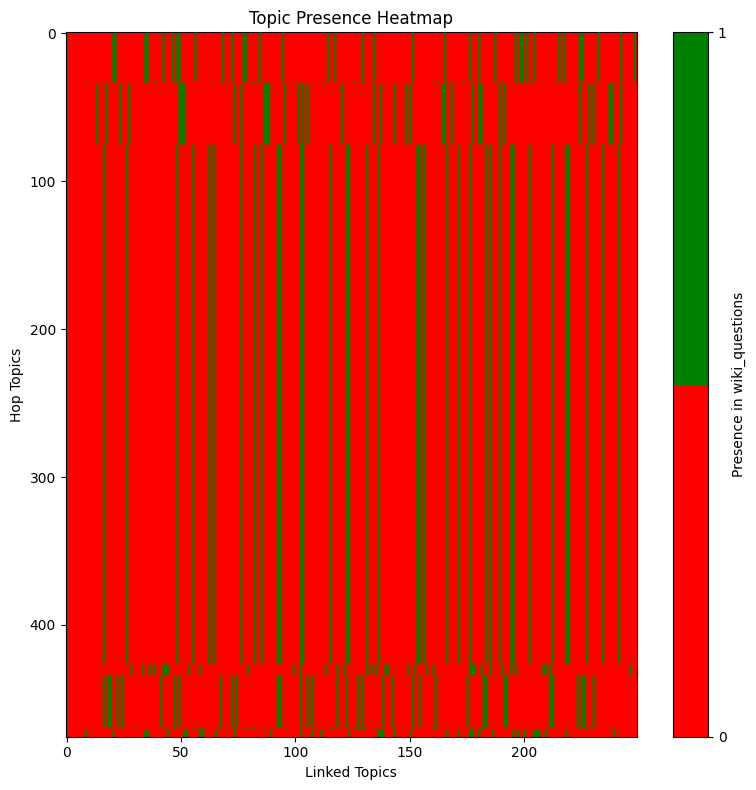

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample structure of your data:
# hop_topics = {'TopicA': ['topic1', 'topic2', ..., 'topic500'], ...}
# wiki_questions = {'topic1': '...', 'topic3': '...', ...}

def plot_presence_heatmap(hop_topics, wiki_questions):
    topics = list(hop_topics.keys())
    matrix = []

    for topic in topics:
        row = [
            1 if t in wiki_questions else 0
            for t in hop_topics[topic]
        ]
        # make into an array
        row = np.array(row)
        
        matrix.append(row)

    matrix = np.array(matrix)
    
    
    # Convert each row to a binary number and get its decimal representation
    row_values = matrix.dot(1 << np.arange(matrix.shape[1] - 1, -1, -1))
    # Get sorted indices based on these decimal values
    sorted_indices = np.argsort(row_values)[::-1]  # Use [::-1] for descending
    # Apply the sorting
    matrix = matrix[sorted_indices]
    
    ###
    # Define a custom colormap: 0 = red, 1 = green
    from matplotlib.colors import ListedColormap
    cmap = ListedColormap(['red', 'green'])

    plt.figure(figsize=(8, 8))
    plt.imshow(matrix, aspect='auto', cmap=cmap)

    plt.xlabel('Linked Topics')
    plt.ylabel('Hop Topics')
    #plt.yticks(ticks=np.arange(len(topics)), labels=topics)
    plt.colorbar(label='Presence in wiki_questions', ticks=[0, 1])
    plt.title('Topic Presence Heatmap')

    plt.tight_layout()
    plt.show()

# Example usage
# plot_presence_heatmap(hop_topics, wiki_questions)
plot_presence_heatmap(hop_topics, wiki_questions)


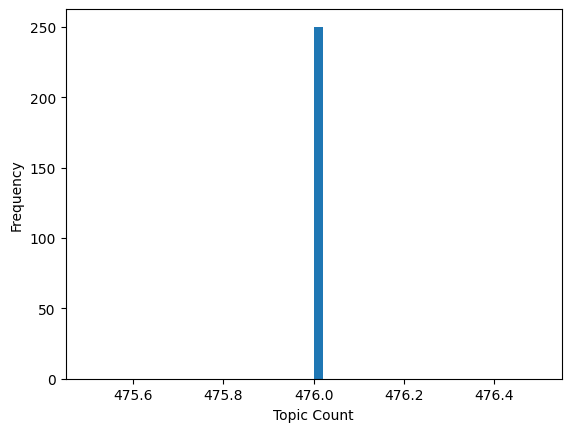

what is the overlap between row 0 and row 1?
key 1 SpyCEP (Streptococcus pyogenes) -- 250
key 2 Horizontal gene transfer in microbes -- 250
250


In [ ]:
topic_count = {}
for base_topic in hop_topics.keys():
    for t in hop_topics[base_topic]:
        if t not in topic_count:
            topic_count[t] = 0
        topic_count[t] += 1

# plot topic_count
import matplotlib.pyplot as plt
topic_counts = list(topic_count.values())
plt.hist(topic_counts, bins=50)
plt.xlabel('Topic Count')
plt.ylabel('Frequency')
plt.show()
        

        
print(f"what is the overlap between row 0 and row 1?")
keys = list(hop_topics.keys())
row_0 = hop_topics[keys[0]]
row_1 = hop_topics[keys[1]]
# find any overlap between row_0 and row_1
overlaps = []
print(f"key 1 {keys[0]} -- {len(row_0)}")
print(f"key 2 {keys[1]} -- {len(row_1)}")

for i in range(len(row_0)):
    if row_0[i] == row_1[i]:
        overlaps.append((i, row_0[i]))
print(len(overlaps))

#
# beep boop baap - it seems like this is wrong somehow - the overlap is much larger than I thought it should be
#

In [ ]:
topic_count
# how many facts are there

HOME_DIR = os.path.expanduser("~")
BASE_DIR = Path(HOME_DIR) / "code/data_to_concept_unlearning/"
safe_dual_use_facts_dir = BASE_DIR / "data/safe_facts"
topic_df_savepath =safe_dual_use_facts_dir/ f"question_topic_df_bio.json"
topic_df = pd.read_json(topic_df_savepath, orient="records", lines=True)
print(f"topic_df.shape - {topic_df.shape}")
topic_df.head()

wiki_facts_path = data_cache / "wiki_facts_750__2025-04-17.json"
if os.path.exists(wiki_facts_path):
    wiki_facts = load_dict(wiki_facts_path)
print(f"wiki_facts.keys() - {len(wiki_facts.keys())}")

In [ ]:
wiki_keys = list(wiki_facts.keys())
np.random.shuffle(wiki_keys)
print(wiki_keys[:10])

['English Defence League', 'Boeing EA-18G Growler', 'Damsel in Distress', '2015 Tianjin explosions', 'Inverted sugar syrup', 'List of countries by oil production', 'Largest living flying birds by wingspan', 'Thyroid', 'Gela Nash-Taylor', 'Colostrum']


In [ ]:
# TODO now: 
# 1. save the topics (given this ordering)
# 2. extract facts from the topics, and save them < look to `# Extracting Facts from wikipedia, and saving them!`
# 3. generate a dataset of questions from these facts.
# interpolate and plot
beep boop baap

# evaluate model with safe-fact RAG content on base-model and on ELM-model


In [ ]:
if construct_safe_dataset_from_wiki_rag:
    # add facts to the context of the model
    query = df_bio.iloc[0].question
    relevant_chunks = facts
    #answer = generate_answer(relevant_chunks, query)
    #answer

    context = "\n".join(facts[:])
    row = df_bio.iloc[0]
    print(f"correct answer: {row.answer}")
    prompt = f"Context:\n{context}\n\nQuestion: {query}\nAnswer:"
    print(prompt)
    # ask ELM
    reload(metrics)
    model_response = metrics.answer_single_question(model, tokenizer,
                                                    prompt).item()
    elm_model_response = metrics.answer_single_question(
        elm_model, elm_tokenizer, prompt).item()
    print(
        f"corret: {row.answer}; \nmodel_response: {model_response}; \n elm_model_response: {elm_model_response}"
    )
    #qa_pipeline(prompt)[0]["generated_text"]

    ###
    print(f"base model - no RAG")
    model_response = metrics.answer_single_question(model, tokenizer,
                                                    query).item()
    elm_model_response = metrics.answer_single_question(
        elm_model, elm_tokenizer, query).item()
    print(
        f"corret: {row.answer}; \nmodel_response: {model_response}; \n elm_model_response: {elm_model_response}"
    )

    #qa_pipeline(prompt)[0]["generated_text"]
